In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

****
# Import Datasets
****

In [2]:
path_001 = '../data/Project1 Data export_001.tsv'
path_002 = '../data/Project1 Data export_002.tsv'
path_003 = '../data/Project1 Data export_003.tsv'
path_004 = '../data/Project1 Data export_004.tsv'
path_005 = '../data/Project1 Data export_005.tsv'
path_list = [path_001, path_002, path_003, path_004, path_005]

In [3]:
# Read the tsv file and return the dataframe
def read_tsv(path):
    df = pd.read_csv(path,sep='\t')
    expected_tasks = [f"Task {i}" for i in range(1, 7)]
    expected_tasks = expected_tasks + [f"Task {i} end" for i in range(1, 7)]
    task_counts = df['Event'].value_counts()
    for task in expected_tasks:
        if task not in task_counts or task_counts[task] != 6:
            # raise ValueError(f"Mislabeling detected: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
            print(f"Mislabeling detected for file {path}: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
    return df

In [4]:
all_files = []
for i in range(len(path_list)):
    file = read_tsv(path_list[i])
    all_files.append(file)


C:\Users\kruu\AppData\Local\Temp\ipykernel_24472\2691225492.py:3: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')


****
# Task range identification
****

In [5]:
# The frequency of recording is 120Hz, that's why consecutive timestamps are at least 8.33ms apart
(all_files[0]["Recording timestamp"].diff()/1e6).value_counts()

Recording timestamp
0.008333    63233
0.008334    30942
0.008332     9322
0.008331     2465
0.008335     1571
            ...  
0.097263        1
0.004968        1
0.003702        1
0.001992        1
0.164029        1
Name: count, Length: 8369, dtype: int64

In [6]:
# The unit of the timestamp is in microsecond
#Duration of the screen recording in minutes
print(f"Duration of screen recording in min: {(all_files[0].query('Event == "ScreenRecordingEnd"')['Recording timestamp'].values - all_files[0].query('Event == "ScreenRecordingStart"')['Recording timestamp'].values).item()/(1e6 * 60)}")

#Total duration of the recording in minutes (unit of the columns, miliseconds)
print(f"Total duration in min: {all_files[0]["Recording duration"].unique().item()/(1000*60)}")

Duration of screen recording in min: 18.937161516666666
Total duration in min: 20.649416666666667


In [13]:
db = all_files[0]
db = db.loc[db['Event'].str.contains('Task', na=False)][["Event","Recording timestamp"]]
db = db.sort_values(by="Recording timestamp").reset_index(drop=True)

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
task_ranges = {task: [] for task in tasks}
task_stack = {}

for _, row in db.iterrows():
    event, timestamp = row["Event"], row["Recording timestamp"]
    
    if "Task" in event and "end" not in event:  # Task Start
        task_type = event
        task_stack[task_type] = timestamp  # Store start time

    elif "end" in event:  # Task End
        task_type = event.replace(" end", "")  # Get task type
        if task_type in task_stack:  # Ensure matching start exists
            start_time = task_stack.pop(task_type)  # Retrieve start time
            task_ranges[task_type].append((start_time, timestamp))

task_ranges

{'Task 1': [(208319520, 251630478),
  (458044103, 498409404),
  (734425973, 753879780),
  (827283973, 858555320),
  (869609973, 885787735),
  (1208263919, 1233579967)],
 'Task 2': [(559221769, 582818964),
  (685235973, 702248206),
  (708658973, 727626502),
  (893291339, 907212000),
  (1168181524, 1181777568),
  (1189745919, 1200335273)],
 'Task 3': [(259413536, 280871127),
  (289904162, 306003607),
  (535555769, 554065820),
  (664384973, 676636563),
  (939351224, 954397846),
  (960636224, 975901297)],
 'Task 4': [(320053103, 341031533),
  (346531353, 371263820),
  (425124426, 446865343),
  (912629973, 931911146),
  (980995224, 1022420542),
  (1139621524, 1160540807)],
 'Task 5': [(140626132, 167050138),
  (172154122, 197349067),
  (1031277224, 1060985858),
  (1061881661, 1082243463),
  (1086839524, 1103271908),
  (1111566524, 1131358458)],
 'Task 6': [(384650848, 414766471),
  (506481709, 526841374),
  (595375103, 625850814),
  (633562973, 655999791),
  (761980973, 785028668),
  (79093

In [16]:
# Get the range start and end index for each tastk in tasks
# OUTDATED: If the end of the task is not specified
# def task_range_finder(db, tasks_str):
#     tasks_ranges = {}
#     for task in tasks_str:
#         bounds = []
#         all_start = db.loc[db['Event'].str.contains('Task', na=False)]["Recording timestamp"].to_list()
#         start_task = db.loc[db['Event'] == task, 'Recording timestamp'].to_list()
#         for j in range(len(all_start)):
#             if all_start[j] in start_task:
#                 # If the last task is the last task of the recording: add 1 minute to the end of the task
#                 if j == len(all_start) - 1:
#                     bounds.append([all_start[j], all_start[j] + (60*1e6)])
#                 else:
#                     bounds.append([all_start[j], all_start[j+1] - (5*1e6)])
#         tasks_ranges[task] = bounds
#     return tasks_ranges

def task_range_finder(db, tasks_arr):
    
    event_df = db.loc[db['Event'].str.contains('Task', na=False)][["Event","Recording timestamp"]]
    event_df = event_df.sort_values(by="Recording timestamp").reset_index(drop=True)
    
    task_ranges = {task: [] for task in tasks_arr}
    task_stack = {}

    for _, row in event_df.iterrows():
        event, timestamp = row["Event"], row["Recording timestamp"]
        
        if "Task" in event and "end" not in event:  # Task Start
            task_type = event
            task_stack[task_type] = timestamp  # Store start time

        elif "end" in event:  # Task End
            task_type = event.replace(" end", "")  # Get task type
            if task_type in task_stack:  # Ensure matching start exists
                start_time = task_stack.pop(task_type)  # Retrieve start time
                task_ranges[task_type].append((start_time, timestamp))

    return task_ranges

In [17]:
# Average task duration per person in seconds
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
durations = {task: [] for task in tasks}
for file in all_files:
        tasks_ranges = task_range_finder(file, tasks)
        for task in tasks_ranges:
                durations[task].append(round(np.mean([x[1] - x[0] for x in tasks_ranges[task]]).item()/(1e6),2))
durations

{'Task 1': [29.32, 26.24, 29.46, 35.86, 20.23],
 'Task 2': [16.28, 15.41, 17.44, 14.49, 15.41],
 'Task 3': [16.44, 13.29, 17.16, 14.48, 12.82],
 'Task 4': [24.85, 15.37, 20.88, 19.84, 18.33],
 'Task 5': [22.99, 19.88, 23.65, 20.51, 18.76],
 'Task 6': [25.35, 20.0, 20.0, 18.14, 18.79]}

****
# Data Extraction
****

In [ ]:
# Helper function 

# Longest period of nans in each column
def longest_nan_period(db):
    longest_nan = {}
    for col in db.columns:
        longest_nan[col] = 0
        nan_count = 0
        for i in range(len(db)):
            if pd.isna(db[col].iloc[i]):
                nan_count += 1
            else:
                if nan_count > longest_nan[col]:
                    longest_nan[col] = nan_count
                nan_count = 0
    return longest_nan

#list of all nan periods
def nan_period(db):
    periods_nan = {}
    for col in db.columns:
        nan_count = 0
        for i in range(len(db)):
            if pd.isna(db[col].iloc[i]):
                nan_count += 1
            else:
                if nan_count != 0:
                    if col not in periods_nan:
                        periods_nan[col] = [nan_count]
                    else:
                        periods_nan[col].append(nan_count)
                nan_count = 0
    return periods_nan

In [25]:
# Get the gaze point and mouse position data
def feature_extraction(df, tasks):
    data = []
    tasks_ranges = task_range_finder(df, tasks)
    for task in tasks_ranges:
        for i, period in enumerate(tasks_ranges[task]):
            data_per_task = df.query(f"`Recording timestamp` >= {period[0]} and `Recording timestamp` <= {period[1]}")[['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']]
            data_per_task = data_per_task.ffill().bfill()
            data_per_task["Task"] = int(task[-1])
            data_per_task["Period"] = i
            data.append(data_per_task)
    data = pd.concat(data)
    return data
        

In [26]:
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
dataset = []
for file in all_files:
    dataset.append(feature_extraction(file, tasks))
dataset = pd.concat(dataset)

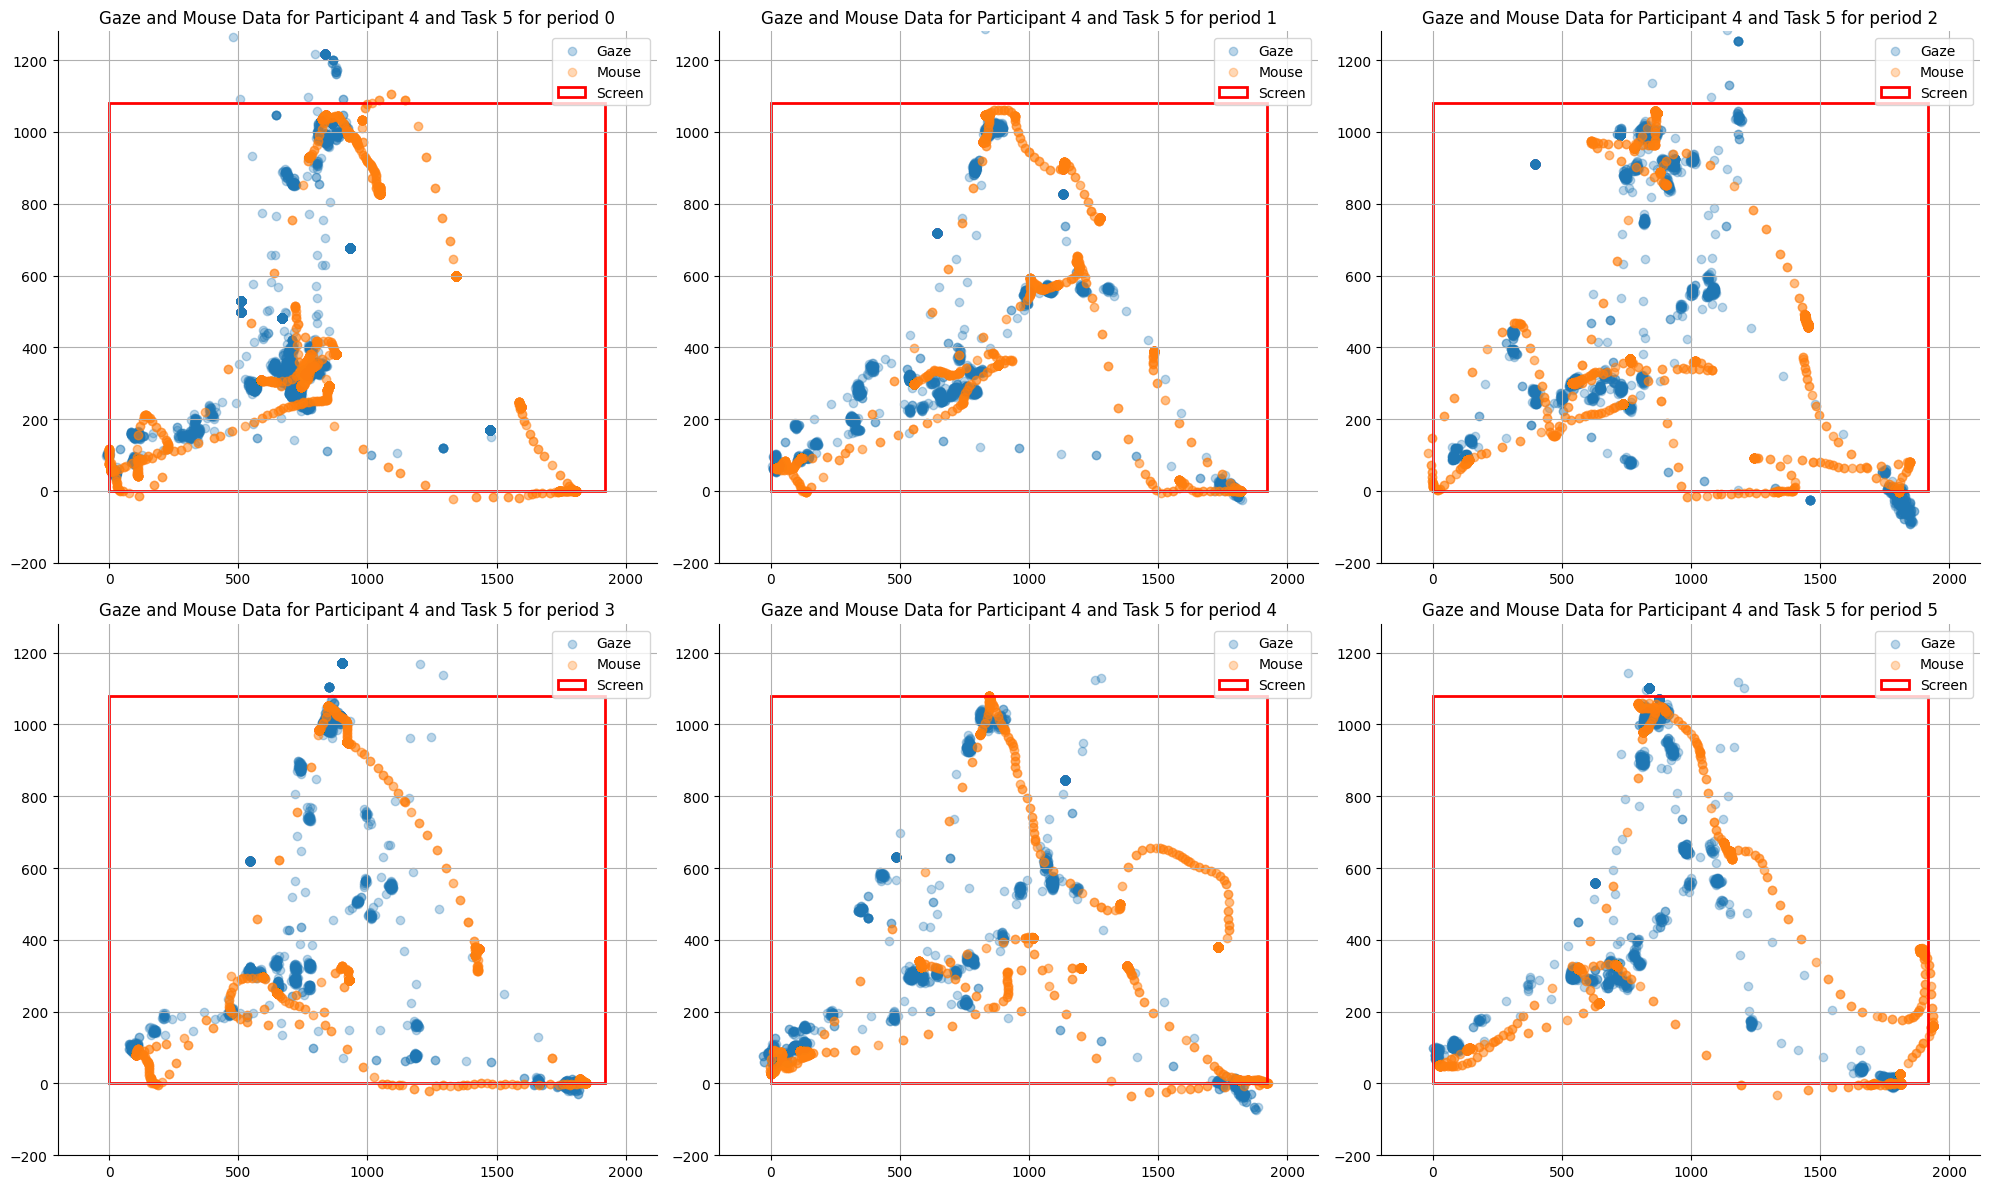

In [37]:
# Comparisons of the different gazes for one task for one participant

name = 4
task = 5

fig, axes = plt.subplots(2, 3, figsize=(20, 12)) 
axes = axes.flatten()
data_plot = dataset.query(f"`Participant name` == {name} and Task == {task}")
for i, period in enumerate(data_plot.Period.unique().tolist()):
    axes[i].scatter(data_plot.query(f"Period == {period}")["Gaze point X"], data_plot.query(f"Period == {period}")["Gaze point Y"], label="Gaze", alpha=0.3)
    axes[i].scatter(data_plot.query(f"Period == {period}")["Mouse position X"], data_plot.query(f"Period == {period}")["Mouse position Y"], label="Mouse", alpha=0.3)
    axes[i].set_title(f"Gaze and Mouse Data for Participant {name} and Task {task} for period {period}")
    axes[i].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
    axes[i].legend()
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True)
    axes[i].set_xlim(-200, 2120)
    axes[i].set_ylim(-200, 1280)

plt.tight_layout()
plt.show()

In [43]:
# Set values of gaze and mouse to Nan if they are outside the screen (+buffer layer of 200 pixels)
# alternative way, we can use the function clip() to set the values to the boundaries of the screen

x_min, x_max = -200, 2120
y_min, y_max = -200, 1280 

dataset["Gaze point X"] = np.where(
    (dataset["Gaze point X"] < x_min) | (dataset["Gaze point X"] > x_max),
    np.nan, 
    dataset["Gaze point X"]
)

dataset["Gaze point Y"] = np.where(
    (dataset["Gaze point Y"] < y_min) | (dataset["Gaze point Y"] > y_max),
    np.nan, 
    dataset["Gaze point Y"]
)

dataset["Mouse position X"] = np.where(
    (dataset["Mouse position X"] < x_min) | (dataset["Mouse position X"] > x_max),
    np.nan, 
    dataset["Mouse position X"]
)

dataset["Mouse position Y"] = np.where(
    (dataset["Mouse position Y"] < y_min) | (dataset["Mouse position Y"] > y_max),
    np.nan, 
    dataset["Mouse position Y"]
)

dataset

,Recording timestamp,Gaze point X,Gaze point Y,Mouse position X,Mouse position Y,Participant name,Task,Period
27196,208319520,1670.0,884.0,NaN,312.0,1,1,0
27197,208319524,1670.0,884.0,NaN,312.0,1,1,0
27198,208320888,1670.0,884.0,NaN,312.0,1,1,0
27199,208327856,1656.0,891.0,NaN,312.0,1,1,0
27200,208335879,1656.0,891.0,NaN,321.0,1,1,0
...,...,...,...,...,...,...,...,...
102032,732509945,1578.0,793.0,1674.0,354.0,5,6,5
102033,732518285,1578.0,793.0,1674.0,354.0,5,6,5
102034,732526619,1578.0,793.0,1674.0,354.0,5,6,5
102035,732534952,1578.0,793.0,1674.0,354.0,5,6,5


In [59]:
# Now per participant, per task and per period, we have to build chunks of 10 seconds for the training samples
# So one specific action of one participant will be represented by several chunks of 10 seconds

chunk_size = 5*1e6
test = dataset.query("`Participant name` == 5 and Task == 1 and Period == 0")
test["Recording timestamp"] = test["Recording timestamp"]
test["chunk_id"] = (test["Recording timestamp"] - test["Recording timestamp"].iloc[0]) // chunk_size

#Get the length of the chunks
test["chunk_id"].value_counts()

C:\Users\kruu\AppData\Local\Temp\ipykernel_24472\1175115101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Recording timestamp"] = test["Recording timestamp"]
C:\Users\kruu\AppData\Local\Temp\ipykernel_24472\1175115101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["chunk_id"] = (test["Recording timestamp"] - test["Recording timestamp"].iloc[0]) // chunk_size


chunk_id
1.0    815
3.0    754
0.0    693
2.0    690
4.0     35
Name: count, dtype: int64

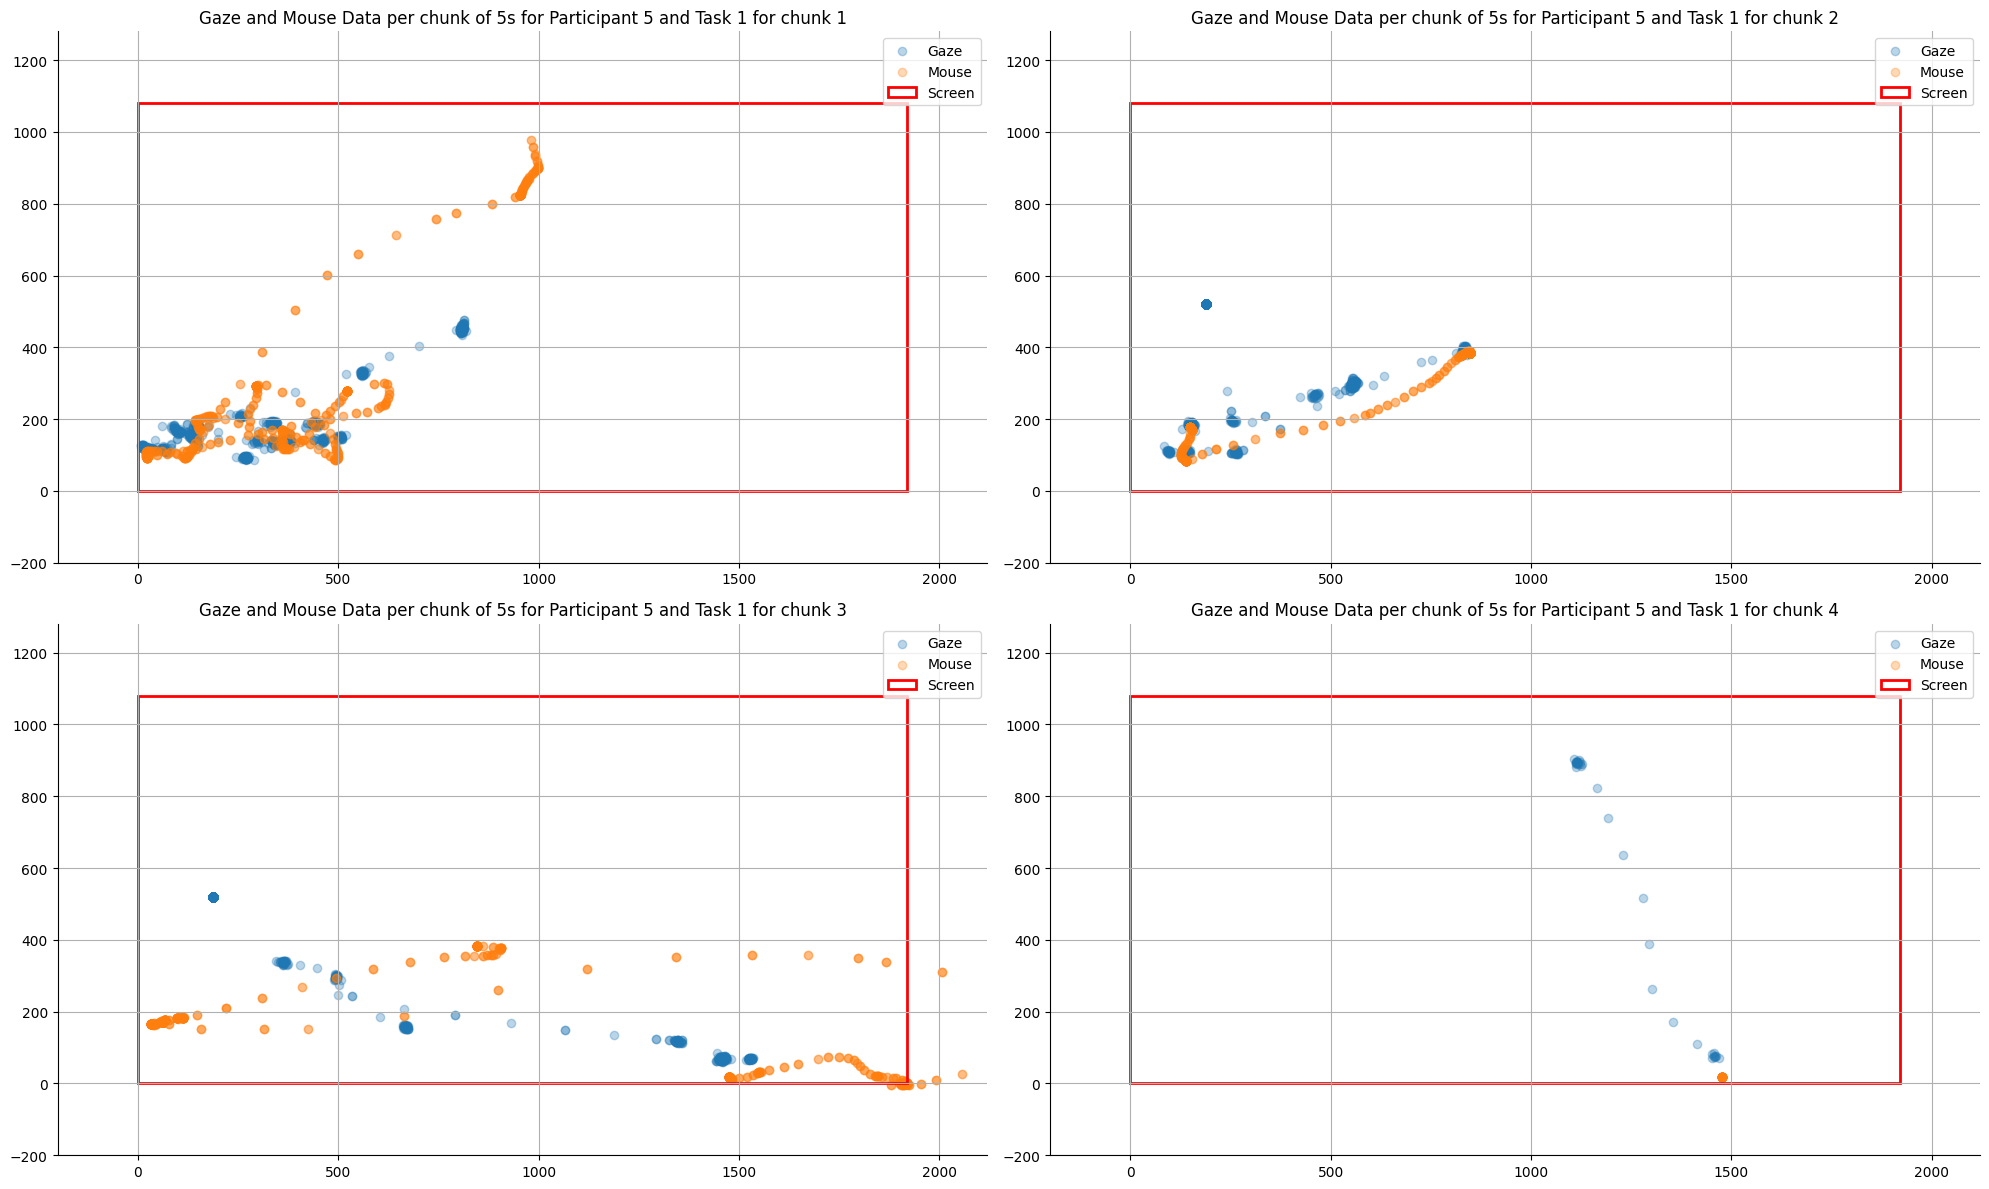

In [61]:
# Comparisons of the chunks for one task for one participant

fig, axes = plt.subplots(2, 2, figsize=(20, 12)) 
axes = axes.flatten()
data_plot = test
for i in range(4):
    axes[i].scatter(data_plot.query(f"chunk_id == {i+1}")["Gaze point X"], data_plot.query(f"chunk_id == {i+1}")["Gaze point Y"], label="Gaze", alpha=0.3)
    axes[i].scatter(data_plot.query(f"chunk_id == {i+1}")["Mouse position X"], data_plot.query(f"chunk_id == {i+1}")["Mouse position Y"], label="Mouse", alpha=0.3)
    axes[i].set_title(f"Gaze and Mouse Data per chunk of 5s for Participant 5 and Task 1 for chunk {i+1}")
    axes[i].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
    axes[i].legend()
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True)
    axes[i].set_xlim(-200, 2120)
    axes[i].set_ylim(-200, 1280)

plt.tight_layout()
plt.show()

### WARNINGS:
- X and Y values can be negatives for the gaze and the mouse. Are they outliers?
- The patterns seem quite different for a same task across the different participants. Are they well identified?
- I think it's interesting to add a marker of outside/inside the screen. Times when they are looking outside is interesting as well. Maybe put them to -1 just as the nans ?
- !!! Do the scaling only on the values that are useful: Nans or outside the screen should not be part of the scaling
- Explore unsupervised learning to classify chunks of time series 
- Instead of training of the full task, train on 10 seconds of observation and classify those 10 seconds with a task. 

****
# Padding
****